# Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, r2_score, precision_score, recall_score, f1_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.transforms import Bbox
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib import rcParams
rcParams['text.usetex'] = True
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

2023-03-13 13:11:28.596035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 13:11:28.690185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 13:11:28.690196: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-13 13:11:28.708948: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-13 13:11:29.194182: W tensorflow/stream_executor/platform/de

# Preprocesing data

## Reading data

In [2]:
n_bound = 1
data_k = pd.read_excel('kernel_50MPa.xlsx',header=None)
data_b = pd.read_excel('bound_50MPa.xlsx', sheet_name=f'Sheet{n_bound}', header=None)

/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
y_data_k = data_k.get(data_k.shape[1]-1)
X_data_k = data_k.drop(columns=data_k.shape[1]-1)
y_data_b = data_b.get(data_b.shape[1]-1) 
X_data_b = data_b.drop(columns=data_b.shape[1]-1)

## Spliting data

In [4]:
# Kernel train test
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_data_k, y_data_k, test_size=0.2)
# Bound train test
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_data_b, y_data_b, test_size=0.2)

In [5]:
# Kernel + Bound train test
X_train_kb = pd.concat([X_train_k, X_train_b], axis=0)
y_train_kb = pd.concat([y_train_k, y_train_b], axis=0)
y_train_c = np.concatenate([np.zeros(y_train_k.shape), np.ones(y_train_b.shape)], axis=0).astype(int)
X_test_kb = pd.concat([X_test_k, X_test_b], axis=0)
y_test_kb = pd.concat([y_test_k, y_test_b], axis=0)
y_test_c = np.concatenate([np.zeros(y_test_k.shape), np.ones(y_test_b.shape)], axis=0).astype(int)

## Preparing data for classification

In [6]:
X_train = X_train_kb.assign(c=y_train_c, y=y_train_kb)
X_train = X_train.sample(frac=1).reset_index(drop=True)
y_train_class = X_train.get('c')
y_train_kb = X_train.get('y')
X_train_kb = X_train.drop(columns=['y','c'])

In [7]:
X_test = X_test_kb.assign(c=y_test_c, y=y_test_kb)
X_test = X_test.sample(frac=1,axis=0).reset_index(drop=True)
y_test_kb = X_test.get('y')
X_test = X_test.drop(columns='y')
y_test_class = X_test.get('c')
X_test_kb = X_test.drop(columns='c')

In [8]:
std_class = StandardScaler()
X_train_kb_std = std_class.fit_transform(X_train_kb, y_train_class)
X_test_kb_std = std_class.transform(X_test_kb)

(array([800.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 800.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

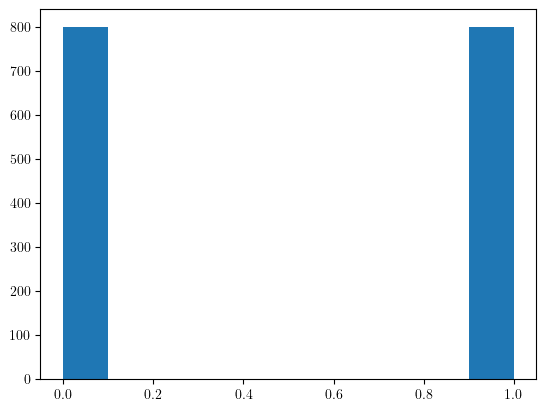

In [9]:
plt.hist(y_train_class)

## Preparing data for regression

In [10]:
std = StandardScaler()
# Kernel --> 
X_train_k_std = std.fit_transform(X_train_k, y_train_k)
# --> Kernel
X_test_k_k_std = std.transform(X_test_k)
# --> Bound
X_test_k_b_std = std.transform(X_test_b)

In [11]:
std2 = StandardScaler()
# Bound --> 
X_train_b_std = std2.fit_transform(X_train_b, y_train_b)
# --> Bound
X_test_b_b_std = std2.transform(X_test_b)
# --> Kernel
X_test_b_k_std = std2.transform(X_test_k)

In [12]:
std3 = StandardScaler()
# Kernel + Bound -->
X_train_kb_std = std3.fit_transform(X_train_kb, y_train_kb)
# --> Kernel
X_test_kb_k_std = std3.transform(X_test_k)
# --> Bound
X_test_kb_b_std = std3.transform(X_test_b)

In [13]:
y_test_b

306    0.000626
523    0.000441
639    0.000515
52     0.000637
392    0.000634
         ...   
220    0.000551
371    0.000594
921    0.000519
489    0.000509
998    0.000618
Name: 6, Length: 200, dtype: float64

# ML Classification models

Logistic Regression Report
               precision    recall  f1-score   support

           0       0.98      0.89      0.93       200
           1       0.90      0.98      0.94       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.93       400
weighted avg       0.94      0.94      0.93       400

0.9385522734146587
0.935
0.934868107918535
SVM Report
               precision    recall  f1-score   support

           0       0.98      0.89      0.93       200
           1       0.90      0.98      0.94       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.93       400
weighted avg       0.94      0.94      0.93       400

0.9385522734146587
0.935
0.934868107918535

 Decision Tree 
 	 mean precision 	 mean recall 	 	 mean fscore 

0.0 	 0.9283 	 	 0.906 	 	 0.917 

1.0 	 0.9082 	 	 0.93 	 	 0.919 

	 std precision 	 	 std recall 	 	 std fscore 

0.0 	 0.0069 	 	 0.0073 	 	 0.0059 


<Figure size 640x480 with 0 Axes>

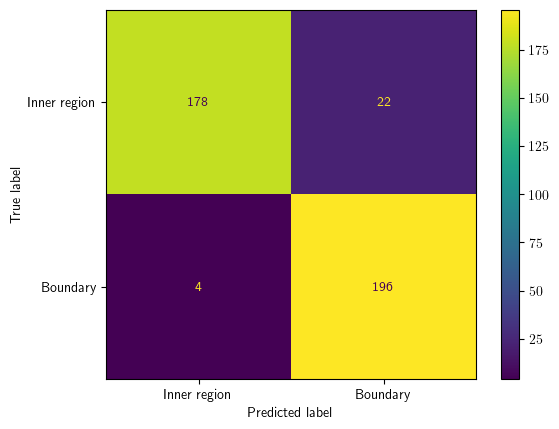

<Figure size 640x480 with 0 Axes>

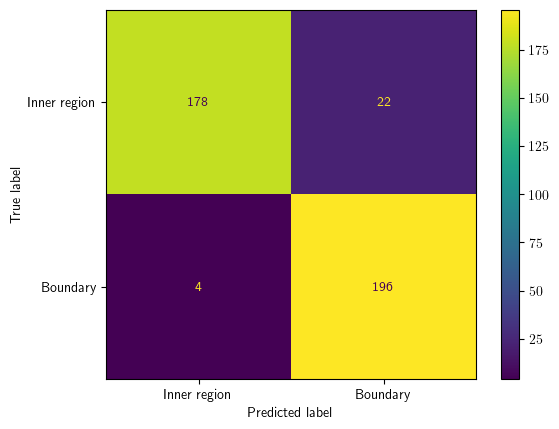

<Figure size 640x480 with 0 Axes>

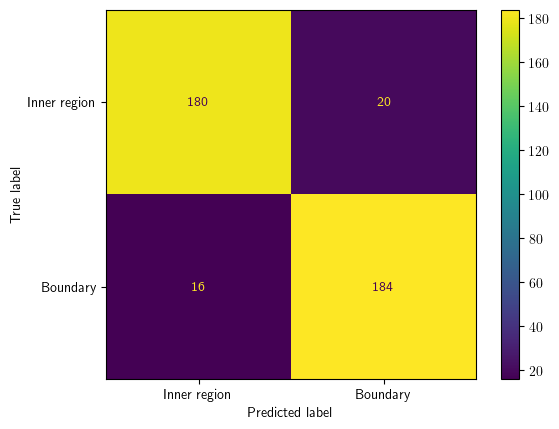

<Figure size 640x480 with 0 Axes>

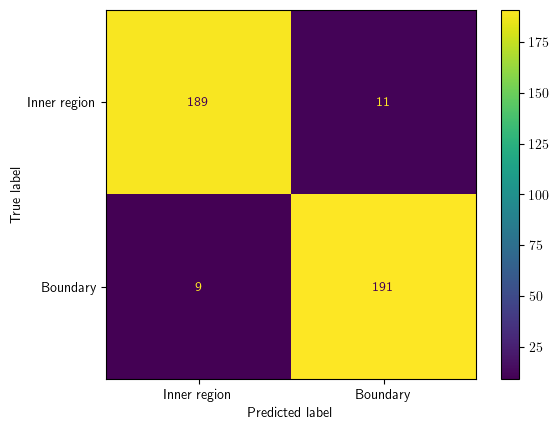

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

#LR
lr = LogisticRegression()
lr.fit(X_train_kb_std, y_train_class)
y_predict_lr = lr.predict(X_test_kb_std)
print('Logistic Regression Report\n', classification_report(y_test_class, y_predict_lr))
print(precision_score(y_test_class, y_predict_lr, average='weighted'))
print(recall_score(y_test_class, y_predict_lr, average='weighted'))
print(f1_score(y_test_class, y_predict_lr, average='weighted'))

#SVC
svc = SVC()
svc.fit(X_train_kb_std, y_train_class)
y_predict_svc = svc.predict(X_test_kb_std)
print('SVM Report\n', classification_report(y_test_class, y_predict_svc))
print(precision_score(y_test_class, y_predict_svc, average='weighted'))
print(recall_score(y_test_class, y_predict_svc, average='weighted'))
print(f1_score(y_test_class, y_predict_svc, average='weighted'))

#DT
precision_dt = []
recall_dt = []
fscore_dt = []
support_dt = []
precision_score_dt = []
recall_score_dt = []
f1_score_dt = []
for r in range(5):
    dt = DecisionTreeClassifier()
    dt.fit(X_train_kb_std, y_train_class)
    y_predict_dt = dt.predict(X_test_kb_std)
    precision,recall,fscore,support=score(y_test_class, y_predict_dt, average=None)
    precision_dt.append(precision)
    recall_dt.append(recall)
    fscore_dt.append(fscore)
    support_dt.append(support)

    p_s = precision_score(y_test_class, y_predict_dt, average='weighted')
    r_s = recall_score(y_test_class, y_predict_dt, average='weighted')
    f_s = f1_score(y_test_class, y_predict_dt, average='weighted')

    precision_score_dt.append(p_s)
    recall_score_dt.append(r_s)
    f1_score_dt.append(f_s)

precision_dt = np.array(precision_dt)
mean_precision_dt = np.mean(precision_dt, axis=0)
std_precision_dt = np.std(precision_dt, axis=0)

recall_dt = np.array(recall_dt)
mean_recall_dt = np.mean(recall_dt, axis=0)
std_recall_dt = np.std(recall_dt, axis=0)

fscore_dt = np.array(fscore_dt)
mean_fscore_dt = np.mean(fscore_dt, axis=0)
std_fscore_dt = np.std(fscore_dt, axis=0)

support_dt = np.array(support_dt)
mean_support_dt = np.mean(support_dt, axis=0)
std_support_dt = np.std(support_dt, axis=0)

print('\n','Decision Tree', '\n', '\t', 'mean precision', '\t', 'mean recall', '\t \t', 'mean fscore','\n')
print('0.0', '\t', round(mean_precision_dt[0], 4), '\t \t', round(mean_recall_dt[0], 4), '\t \t', round(mean_fscore_dt[0], 4), '\n')
print('1.0', '\t', round(mean_precision_dt[1], 4), '\t \t', round(mean_recall_dt[1], 4), '\t \t', round(mean_fscore_dt[1], 4), '\n')
print('\t', 'std precision', '\t \t', 'std recall', '\t \t', 'std fscore','\n')
print('0.0','\t', round(std_precision_dt[0], 4), '\t \t', round(std_recall_dt[0], 4), '\t \t', round(std_fscore_dt[0], 4), '\n')
print('1.0','\t', round(std_precision_dt[1], 4), '\t \t', round(std_recall_dt[1], 4), '\t \t', round(std_fscore_dt[1], 4), '\n')

print(np.mean(precision_score_dt))
print(np.mean(recall_score_dt))
print(np.mean(f1_score_dt))
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

#RF
precision_rf = []
recall_rf = []
fscore_rf = []
support_rf = []
precision_score_rf = []
recall_score_rf = []
f1_score_rf = []
for r in range(5):
    rf = RandomForestClassifier()
    rf.fit(X_train_kb_std, y_train_class)
    y_predict_rf = rf.predict(X_test_kb_std)
    precision,recall,fscore,support=score(y_test_class, y_predict_dt, average=None)
    precision_rf.append(precision)
    recall_rf.append(recall)
    fscore_rf.append(fscore)
    support_rf.append(support)

    p_s = precision_score(y_test_class, y_predict_rf, average='weighted')
    r_s = recall_score(y_test_class, y_predict_rf, average='weighted')
    f_s = f1_score(y_test_class, y_predict_rf, average='weighted')

    precision_score_rf.append(p_s)
    recall_score_rf.append(r_s)
    f1_score_rf.append(f_s)

precision_rf = np.array(precision_rf)
mean_precision_rf = np.mean(precision_rf, axis=0)
std_precision_rf = np.std(precision_rf, axis=0)

recall_rf = np.array(recall_rf)
mean_recall_rf = np.mean(recall_rf, axis=0)
std_recall_rf= np.std(recall_rf, axis=0)

fscore_rf = np.array(fscore_rf)
mean_fscore_rf = np.mean(fscore_rf, axis=0)
std_fscore_rf = np.std(fscore_rf, axis=0)


support_rf = np.array(support_rf)
mean_support_rf = np.mean(support_rf, axis=0)
std_support_rf = np.std(support_rf, axis=0)

print('\n','Random Forest', '\n', '\t', 'mean precision', '\t', 'mean recall', '\t \t', 'mean fscore','\n')
print('0.0', '\t', round(mean_precision_rf[0], 4), '\t \t', round(mean_recall_rf[0], 4), '\t \t', round(mean_fscore_rf[0], 4), '\n')
print('1.0', '\t', round(mean_precision_rf[1], 4), '\t \t', round(mean_recall_rf[1], 4), '\t \t', round(mean_fscore_rf[1], 4), '\n')
print('\t', 'std precision', '\t \t', 'std recall', '\t \t', 'std fscore','\n')
print('0.0','\t', round(std_precision_rf[0], 4), '\t \t \t', round(std_recall_rf[0], 4), '\t \t \t', round(std_fscore_rf[0], 4), '\n')
print('1.0','\t', round(std_precision_rf[1], 4), '\t \t \t', round(std_recall_rf[1], 4), '\t \t \t', round(std_fscore_rf[1], 4), '\n')

print(np.mean(precision_score_rf))
print(np.mean(recall_score_rf))
print(np.mean(f1_score_rf))

ppres_lr = precision_score(y_test_class, y_predict_lr, average='weighted')
prec_lr = recall_score(y_test_class, y_predict_lr, average='weighted')
pf1_lr = f1_score(y_test_class, y_predict_lr, average='weighted')

ppres_svc = precision_score(y_test_class, y_predict_svc, average='weighted')
prec_svc = recall_score(y_test_class, y_predict_svc, average='weighted')
pf1_svc = f1_score(y_test_class, y_predict_svc, average='weighted')

print(f'LogR & {round(ppres_lr,5)} & {round(prec_lr,5)} & {round(pf1_lr,5)} \\\\')
print(f'SVC & {round(ppres_svc,5)} & {round(prec_svc,5)} & {round(pf1_svc,5)} \\\\')
print(f'DT$_5$ & {round(np.mean(precision_score_dt),5)} & {round(np.mean(recall_score_dt),5)} & {round(np.mean(f1_score_dt),5)} \\\\')
print(f'RF$_5$ & {round(np.mean(precision_score_rf),5)} & {round(np.mean(recall_score_rf),5)} & {round(np.mean(f1_score_rf),5)} \\\\')


fig1 = plt.figure()
metrics.ConfusionMatrixDisplay.from_predictions(y_test_class, y_predict_lr,display_labels=["Inner region", "Boundary"])
plt.savefig('./figures/50MPa-confusion_matrix_lr.eps')
plt.show()

fig2 = plt.figure()
metrics.ConfusionMatrixDisplay.from_predictions(y_test_class, y_predict_svc,display_labels=["Inner region", "Boundary"])
plt.savefig('./figures/50MPa-confusion_matrix_svc.eps')
plt.show()

fig3 = plt.figure()
metrics.ConfusionMatrixDisplay.from_predictions(y_test_class, y_predict_dt,display_labels=["Inner region", "Boundary"])
plt.savefig('./figures/50MPa-confusion_matrix_dt.eps')
plt.show()

fig4 = plt.figure()
metrics.ConfusionMatrixDisplay.from_predictions(y_test_class, y_predict_rf,display_labels=["Inner region", "Boundary"])
plt.savefig('./figures/50MPa-confusion_matrix_rf.eps')
plt.show()

# Regression problem

## Testing the Kernel

### Kernel --> Kernel

In [15]:
#Kernel data
#Train data', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
#data_k_train = pd.read_excel('train_kernel_bound_forKernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#### Regression models

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

mlp = MLPRegressor(learning_rate='constant', activation='logistic', alpha= 0.05, hidden_layer_sizes= (50, 100, 50), solver= 'adam')
mlp.fit(X_train_k_std, y_train_k)
y_predict_mlp_k = mlp.predict(X_test_k_k_std)

# mlp = MLPRegressor()
# param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#          'activation': ['relu','tanh','logistic'],
#          'alpha': [0.0001, 0.05, 0.1],
#          'learning_rate': ['constant','adaptive'],
#          'solver': ['adam','sgd']}

# gsc = GridSearchCV(mlp,param_grid,cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

# grid_result = gsc.fit(X_train_k_std, y_train_k)

# print(grid_result.best_params_)

# y_predict_mlp_k = gsc.predict(X_test_k_k_std)


lr = LinearRegression()
lr.fit(X_train_k_std, y_train_k)
y_predict_lr_k = lr.predict(X_test_k_k_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_k_std, y_train_k)
y_predict_svr_k = svr.predict(X_test_k_k_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
rmse_dt = []
r2_dt = []
mape_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_k_std, y_train_k)
    y_predict_dt_k = dt.predict(X_test_k_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_dt_k)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_dt_k))
    r2 = r2_score(y_test_k, y_predict_dt_k)
    mape = mean_absolute_percentage_error(y_test_k, y_predict_dt_k)
    mae_dt.append(mae)
    rmse_dt.append(rmse)
    r2_dt.append(r2)
    mape_dt.append(mape)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

mae_rf = []
rmse_rf = []
r2_rf = []
mape_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_k_std, y_train_k)
    y_predict_rf_k = rf.predict(X_test_k_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_rf_k)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_rf_k))
    r2 = r2_score(y_test_k, y_predict_rf_k)
    mape = mean_absolute_percentage_error(y_test_k, y_predict_rf_k)
    mae_rf.append(mae)
    rmse_rf.append(rmse)
    r2_rf.append(r2)
    mape_rf.append(mape)
    # plt.plot(y_test_k)
    # plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_lr_k))
rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_mlp_k))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_svr_k))
rmse_dt = np.mean(rmse_dt)
rmse_rf = np.mean(rmse_rf)
mae_lr = metrics.mean_absolute_error(y_test_k, y_predict_lr_k)
mae_mlp = metrics.mean_absolute_error(y_test_k, y_predict_mlp_k)
mae_svr = metrics.mean_absolute_error(y_test_k, y_predict_svr_k)
mae_dt = np.mean(mae_dt)
mae_rf = np.mean(mae_rf)
r2_lr = r2_score(y_test_k, y_predict_lr_k)
r2_mlp = r2_score(y_test_k, y_predict_mlp_k)
r2_svr = r2_score(y_test_k, y_predict_svr_k)
r2_dt = np.mean(r2_dt)
r2_rf = np.mean(r2_rf)
mape_lr = mean_absolute_percentage_error(y_test_k, y_predict_lr_k)
mape_mlp = mean_absolute_percentage_error(y_test_k, y_predict_mlp_k)
mape_svr = mean_absolute_percentage_error(y_test_k, y_predict_svr_k)
mape_dt = np.mean(mape_dt)
mape_rf = np.mean(mape_rf)

print('Root Mean Squared Error:''\n', 'LR: ''\t', rmse_lr, '\n', 'MLP: ''\t', rmse_mlp, '\n', 'SVR: ''\t', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
print('Mean Absolute Error:''\n', 'LR: ''\t', mae_lr, '\n', 'MLP: ''\t', mae_mlp, '\n', 'SVR: ''\t', mae_svr, '\n', 'DT: ''\t', mae_dt, '\n', 'RF: ''\t', mae_rf, '\n', )
print('R2 Score:''\n', 'LR: ''\t', r2_lr, '\n', 'MLP: ''\t', r2_mlp, '\n', 'SVR: ''\t', r2_svr, '\n', 'DT: ''\t', r2_dt, '\n', 'RF: ''\t', r2_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_lr, '\n', 'MLP: ''\t', mape_mlp, '\n', 'SVR: ''\t', mape_svr, '\n', 'DT: ''\t', mape_dt, '\n', 'RF: ''\t', mape_rf, '\n', )

print(f'LR & {round(rmse_lr,5)} & {round(mae_lr,5)} & {round(r2_lr,5)} & {round(mape_lr,5)} \\\\')
print(f'SVR & {round(rmse_svr,5)} & {round(mae_svr,5)} & {round(r2_svr,5)} & {round(mape_svr,5)} \\\\')
print(f'DT$_5$ & {round(rmse_dt,5)} & {round(mae_dt,5)} & {round(r2_dt,5)} & {round(mape_dt,5)} \\\\')
print(f'RF$_5$ & {round(rmse_rf,5)} & {round(mae_rf,5)} & {round(r2_rf,5)} & {round(mape_rf,5)} \\\\')
print(f'MLP & {round(rmse_mlp,5)} & {round(mae_mlp,5)} & {round(r2_mlp,5)} & {round(mape_mlp,5)} \\\\')

Root Mean Squared Error:
 LR: 	 0.00014141283280445682 
 MLP: 	 0.0012863064019818916 
 SVR: 	 0.00023610746585550643 
 DT: 	 0.00016495908310813946 
 RF: 	 0.00011570375720751578 

Mean Absolute Error:
 LR: 	 0.00011022635201156376 
 MLP: 	 0.0012308375863342824 
 SVR: 	 0.00019542187590480592 
 DT: 	 0.00013017482602613157 
 RF: 	 9.252186406416786e-05 

R2 Score:
 LR: 	 0.6407542654013141 
 MLP: 	 -28.723697869767747 
 SVR: 	 -0.0014595579401923686 
 DT: 	 0.5108990185538366 
 RF: 	 0.7594650385766621 

MAPE Score:
 LR: 	 0.07027675072331875 
 MLP: 	 0.785068269644697 
 SVR: 	 0.12262567743714019 
 DT: 	 0.08217761723797959 
 RF: 	 0.05983703142930454 

LR & 0.00014 & 0.00011 & 0.64075 & 0.07028 \\
SVR & 0.00024 & 0.0002 & -0.00146 & 0.12263 \\
DT$_5$ & 0.00016 & 0.00013 & 0.5109 & 0.08218 \\
RF$_5$ & 0.00012 & 9e-05 & 0.75947 & 0.05984 \\
MLP & 0.00129 & 0.00123 & -28.7237 & 0.78507 \\


### ML vs True comparison

test_df_k = X_test_k.copy()
test_df_k.insert(len(test_df_k.columns), 'true', y_test_k)
test_df_k.insert(len(test_df_k.columns), 'lr_predict', y_predict_lr_k)
test_df_k.insert(len(test_df_k.columns), 'mlp_predict', y_predict_mlp_k)
test_df_k.insert(len(test_df_k.columns), 'svr_predict', y_predict_svr_k)
test_df_k.insert(len(test_df_k.columns), 'dt_predict', y_predict_dt_k)
test_df_k.insert(len(test_df_k.columns), 'rf_predict', y_predict_rf_k)
test_df_k

train_df_k = X_train_k.copy()
train_df_k.insert(len(train_df_k.columns), 'true', y_train_k)
train_df_k.insert(len(train_df_k.columns), 'lr_predict', lr.predict(X_train_k_std))
train_df_k.insert(len(train_df_k.columns), 'mlp_predict', mlp.predict(X_train_k_std))
train_df_k.insert(len(train_df_k.columns), 'svr_predict', svr.predict(X_train_k_std))
train_df_k.insert(len(train_df_k.columns), 'dt_predict', dt.predict(X_train_k_std))
train_df_k.insert(len(train_df_k.columns), 'rf_predict', rf.predict(X_train_k_std))
train_df_k

df_k = pd.concat([train_df_k, test_df_k], ignore_index=True, axis=0)
df_k.to_csv('./data/kernel-with-predictions.csv', index=False)
df_k

### Heat map

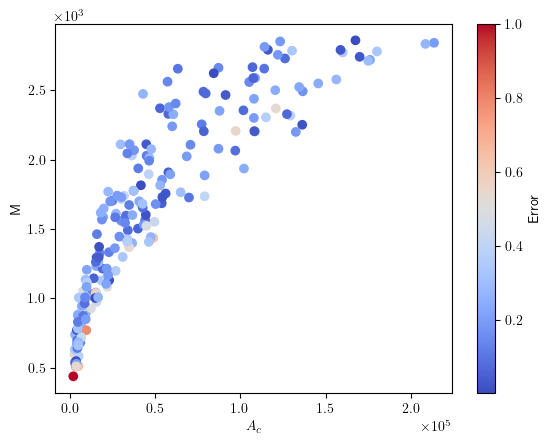

In [17]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_k)
col1 = np.abs(y_test_k - y_predict_rf_k)
col1 = col1/col1.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='coolwarm')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"Error"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/50MPa-heatmap-kernel-error-predictwithclass.eps',format='eps',dpi=300)
plt.show()

### Heat map

<Figure size 640x480 with 0 Axes>

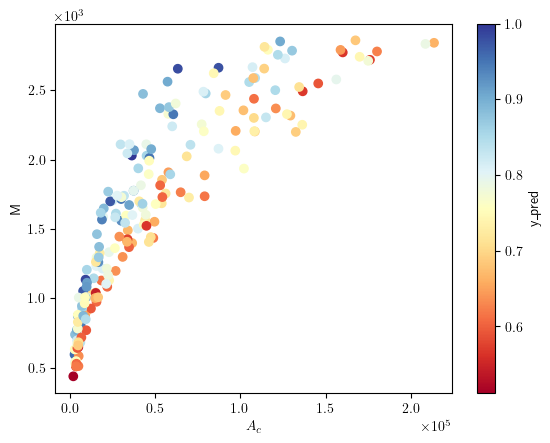

In [18]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_k)
col1 = y_test_k
col1 = col1/col1.max()
plt.show()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='RdYlBu')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"y_pred"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/50MPa-heatmap-kernel-real.eps',format='eps',dpi=300)
plt.show()

In [19]:
print(X_train_k_std.shape)
print(y_train_k.shape)

(800, 6)
(800,)


In [20]:
# # TENSORFLOW
# def build_model():
#     model = keras.Sequential([
#         layers.Conv1D(16, 1, input_shape=[X_train_b_std.shape[1],1]),
#         layers.Conv1D(8, 1),
#         layers.Conv1D(4, 1),
#         #layers.Dense(32, activation='relu', input_shape=[X_train_b_std.shape[1]]),
#         #layers.Dropout(0.1),
#         #layers.Dense(16, activation='relu'),
#         #layers.Dropout(0.1),
#         layers.Flatten(),
#         layers.Dense(4, activation='relu'),
#         #layers.Dropout(0.1),
#         layers.Dense(1, activation='linear')
#     ])

#     optimizer = tf.keras.optimizers.Adam(0.001)

#     model.compile(loss='mse',
#         optimizer=optimizer,
#         metrics=['mae', 'mse'])
#     return model


# model = build_model()
# model.summary()

# def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Abs Error [Strain]')
#     plt.plot(hist['epoch'], hist['mae'])
#     plt.ylabel('Mean Square Error [$Strain^2$]')
#     plt.plot(hist['epoch'], hist['mse'], label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
#     plt.legend()
#     plt.show()


# #early_stop = keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, min_delta=1e-10)


# history = model.fit(X_train_b_std, y_train_b, epochs=1000, validation_split = 0.2, verbose=1)

# plot_history(history)

# test_predictions = model.predict(X_test_b_b_std).flatten()

# print(test_predictions.shape)
# print(y_test_b.shape)

# plt.scatter(y_test_b, test_predictions)
# plt.xlabel('True Values [Strain]')
# plt.ylabel('Predictions [Strain]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# _ = plt.plot([-100, 100], [-100, 100])
# plt.show()

# error = test_predictions - y_test_b
# plt.hist(error, bins = 25)
# plt.xlabel("Prediction Error [Strain]")
# _ = plt.ylabel("Count")
# plt.show()

# rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_b, test_predictions))
# mae_mlp = metrics.mean_absolute_error(y_test_b, test_predictions)
# r2_mlp = r2_score(y_test_b, test_predictions)
# mape_mlp = mean_absolute_percentage_error(y_test_b, test_predictions)

# print(f'RSME: {rmse_mlp} \n MAE: {mae_mlp} \n R2: {r2_mlp} \n MAPE: {mape_mlp} \n')

#### TENSORFLOW
def build_model():
    model = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=[X_train_kb_std.shape[1]]),
        layers.Dropout(0.1),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse'])
    return model


model = build_model()
model.summary()

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Strain]')
    plt.plot(hist['epoch'], hist['mae'])
    plt.ylabel('Mean Square Error [$Strain^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.show()


#early_stop = keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, min_delta=1e-10)


history = model.fit(X_train_kb_std, y_train_kb, epochs=1000, validation_split = 0.2, verbose=1)

plot_history(history)

test_predictions = model.predict(X_test_kb_std).flatten()

plt.scatter(y_test_kb[y_test_class==1], test_predictions[y_test_class==1])
plt.xlabel('True Values [Strain]')
plt.ylabel('Predictions [Strain]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

error = test_predictions[y_test_class==1] - y_test_kb[y_test_class==1]
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Strain]")
_ = plt.ylabel("Count")
plt.show()

rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], test_predictions[y_test_class==1]))
mae_mlp = metrics.mean_absolute_error(y_test_kb[y_test_class==1], test_predictions[y_test_class==1])
r2_mlp = r2_score(y_test_kb[y_test_class==1], test_predictions[y_test_class==1])
mape_mlp = mean_absolute_percentage_error(y_test_kb[y_test_class==1], test_predictions[y_test_class==1])

print(f'RMSE: {rmse_mlp} \n MAE: {mae_mlp} \n R2: {r2_mlp} \n MAPE: {mape_mlp} \n')

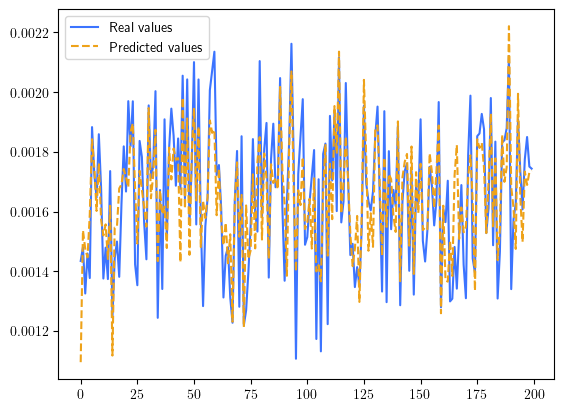

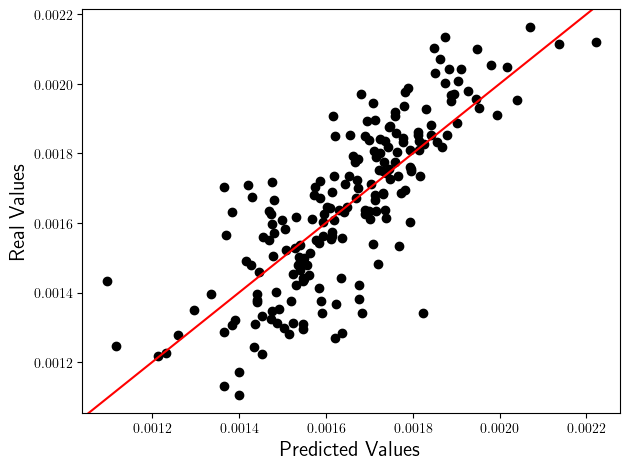

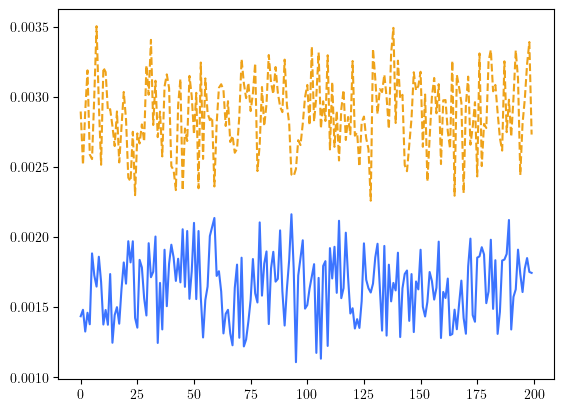

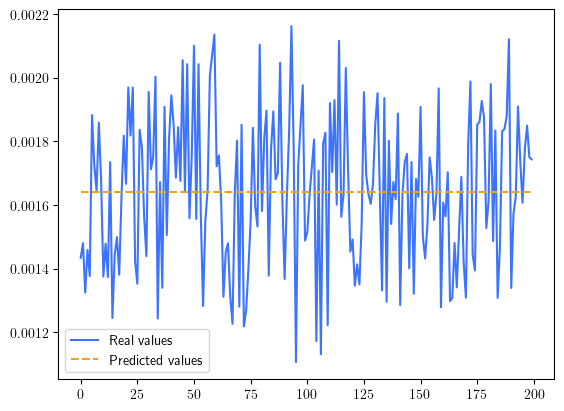

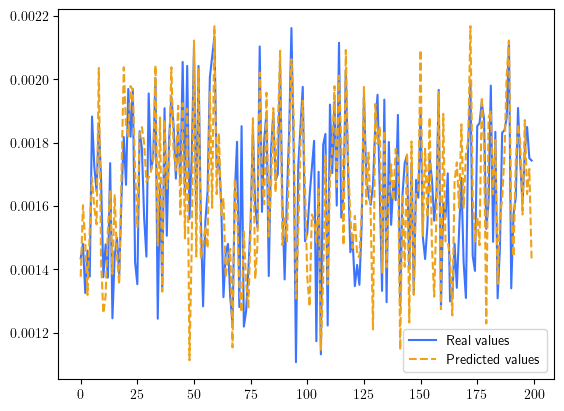

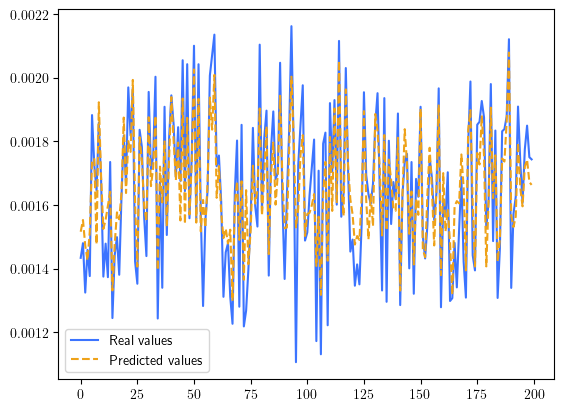

In [21]:
pretty_blue = '#3C74FF'
nice_orange = '#EEA219'

x=np.arange(0,len(y_test_k),1)

fig1_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_lr_k, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig_true_predict_k, ax = plt.subplots()
plt.plot(y_predict_lr_k, y_test_k, 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.tight_layout()
plt.savefig('./figures/50MPa-kernel-regression-true-predict.eps',format='eps',dpi=300)
plt.show()

fig2_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_mlp_k, '--', color=nice_orange, label='Predicted values')

fig3_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_svr_k, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig4_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_dt_k, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig5_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_rf_k, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

#fig6_k = plt.figure()
#plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
#plt.plot(x,test_predictions, '--', color=nice_orange, label='Predicted values')
#plt.legend()
#plt.show()


### Kernel --> Bound

In [22]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#std = StandardScaler()
#X_train_k_std = std.fit_transform(X_train_k, y_train_k)
#X_test_k_std = std.transform(X_test_k)

#### Regression Models

In [23]:
lr = LinearRegression()
lr.fit(X_train_k_std, y_train_k)
y_predict_lr_k = lr.predict(X_test_k_b_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_k_std, y_train_k)
y_predict_svr_k = svr.predict(X_test_k_b_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
mse_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_k_std, y_train_k)
    y_predict_dt_k = dt.predict(X_test_k_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_dt_k)
    mse = metrics.mean_squared_error(y_test_b, y_predict_dt_k)
    mae_dt.append(mae)
    mse_dt.append(mse)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

    
mae_rf = []
mse_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_k_std, y_train_k)
    y_predict_rf_k = rf.predict(X_test_k_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_rf_k)
    mse = metrics.mean_squared_error(y_test_b, y_predict_rf_k)
    mae_rf.append(mae)
    mse_rf.append(mse)  

#rf = RandomForestRegressor()
#rf.fit(X_train_k_std, y_train_k)
#y_predict_rf_k = rf.predict(X_test_k_b_std)
# plt.plot(y_test_k)
# plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_lr_k))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_svr_k))
#rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_dt_k))
#rmse_rf = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_rf_k))
rmse_dt = np.mean(mse_dt)
rmse_rf = np.mean(mse_rf)
print('\n', rmse_lr, '\n', rmse_svr, '\n', rmse_dt, '\n', rmse_rf, '\n', )



 0.0008258590401919822 
 0.0010967915253027156 
 8.161517531217336e-07 
 8.391804217991093e-07 



## Testing the Bound

### Bound --> Bound

In [24]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel_bound_forKernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
#y_test_k = data_k_test.values[:, -1]

#### Regression models

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

mlp = MLPRegressor(learning_rate='constant', activation='logistic', alpha= 0.05, hidden_layer_sizes= (50, 100, 50), solver= 'adam')
mlp.fit(X_train_b_std, y_train_b)
y_predict_mlp_b = mlp.predict(X_test_b_b_std)

lr = LinearRegression()
lr.fit(X_train_b_std, y_train_b)
y_predict_lr_b = lr.predict(X_test_b_b_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_b_std, y_train_b)
y_predict_svr_b = svr.predict(X_test_b_b_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
rmse_dt = []
r2_dt = []
mape_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_b_std, y_train_b)
    y_predict_dt_b = dt.predict(X_test_b_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_dt_b)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_dt_b))
    r2 = r2_score(y_test_b, y_predict_dt_b)
    mape = mean_absolute_percentage_error(y_test_b, y_predict_dt_b)
    mae_dt.append(mae)
    rmse_dt.append(rmse)
    r2_dt.append(r2)
    mape_dt.append(mape)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

mae_rf = []
rmse_rf = []
r2_rf = []
mape_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_b_std, y_train_b)
    y_predict_rf_b = rf.predict(X_test_b_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_rf_b)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_rf_b))
    r2 = r2_score(y_test_b, y_predict_rf_b)
    mape = mean_absolute_percentage_error(y_test_b, y_predict_rf_b)
    mae_rf.append(mae)
    rmse_rf.append(rmse)
    r2_rf.append(r2)
    mape_rf.append(mape)
    # plt.plot(y_test_k)
    # plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_lr_b))
rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_mlp_b))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_svr_b))
rmse_dt = np.mean(rmse_dt)
rmse_rf = np.mean(rmse_rf)
mae_lr = metrics.mean_absolute_error(y_test_b, y_predict_lr_b)
mae_mlp = metrics.mean_absolute_error(y_test_b, y_predict_mlp_b)
mae_svr = metrics.mean_absolute_error(y_test_b, y_predict_svr_b)
mae_dt = np.mean(mae_dt)
mae_rf = np.mean(mae_rf)
r2_lr = r2_score(y_test_b, y_predict_lr_b)
r2_mlp = r2_score(y_test_b, y_predict_mlp_b)
r2_svr = r2_score(y_test_b, y_predict_svr_b)
r2_dt = np.mean(r2_dt)
r2_rf = np.mean(r2_rf)
mape_lr = mean_absolute_percentage_error(y_test_b, y_predict_svr_b)
mape_mlp = mean_absolute_percentage_error(y_test_b, y_predict_mlp_b)
mape_svr = mean_absolute_percentage_error(y_test_b, y_predict_svr_b)
mape_dt = np.mean(mape_dt)
mape_rf = np.mean(mape_rf)

print('Root Mean Squared Error:''\n', 'LR: ''\t', rmse_lr, '\n', 'MLP: ''\t', rmse_mlp, '\n', 'SVR: ''\t', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
print('Mean Absolute Error:''\n', 'LR: ''\t', mae_lr, '\n', 'MLP: ''\t', mae_mlp, '\n', 'SVR: ''\t', mae_svr, '\n', 'DT: ''\t', mae_dt, '\n', 'RF: ''\t', mae_rf, '\n', )
print('R2 Score:''\n', 'LR: ''\t', r2_lr, '\n', 'MLP: ''\t', r2_mlp, '\n', 'SVR: ''\t', r2_svr, '\n', 'DT: ''\t', r2_dt, '\n', 'RF: ''\t', r2_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_lr, '\n', 'MLP: ''\t', mape_mlp, '\n', 'SVR: ''\t', mape_svr, '\n', 'DT: ''\t', mape_dt, '\n', 'RF: ''\t', mape_rf, '\n', )

print(f'LR & {rmse_lr} & {mae_lr} & {round(r2_lr,5)} & {round(mape_lr,5)} \\\\')
print(f'SVR & {rmse_svr} & {mae_svr} & {round(r2_svr,5)} & {round(mape_svr,5)} \\\\')
print(f'DT$_5$ & {rmse_dt} & {mae_dt} & {round(r2_dt,5)} & {round(mape_dt,5)} \\\\')
print(f'RF$_5$ & {rmse_rf} & {mae_rf} & {round(r2_rf,5)} & {round(mape_rf,5)} \\\\')
print(f'MLP & {round(rmse_mlp,5)} & {round(mae_mlp,5)} & {round(r2_mlp,5)} & {round(mape_mlp,5)} \\\\')

Root Mean Squared Error:
 LR: 	 5.147217732696038e-06 
 MLP: 	 0.00016781145101068702 
 SVR: 	 6.694949771288832e-05 
 DT: 	 1.0877894235998307e-05 
 RF: 	 6.551890561317213e-06 

Mean Absolute Error:
 LR: 	 4.042012027642026e-06 
 MLP: 	 0.0001407733408591085 
 SVR: 	 5.479430653469748e-05 
 DT: 	 8.169113501179566e-06 
 RF: 	 4.996795092063083e-06 

R2 Score:
 LR: 	 0.9935251581435669 
 MLP: 	 -5.882199714655206 
 SVR: 	 -0.09541512250964468 
 DT: 	 0.9710792668235637 
 RF: 	 0.9895087712996332 

MAPE Score:
 LR: 	 0.09940131294205372 
 MLP: 	 0.2612839896216079 
 SVR: 	 0.09940131294205372 
 DT: 	 0.01556391142694503 
 RF: 	 0.009519547213322013 

LR & 5.147217732696038e-06 & 4.042012027642026e-06 & 0.99353 & 0.0994 \\
SVR & 6.694949771288832e-05 & 5.479430653469748e-05 & -0.09542 & 0.0994 \\
DT$_5$ & 1.0877894235998307e-05 & 8.169113501179566e-06 & 0.97108 & 0.01556 \\
RF$_5$ & 6.551890561317213e-06 & 4.996795092063083e-06 & 0.98951 & 0.00952 \\
MLP & 0.00017 & 0.00014 & -5.8822 & 

## ML vs True comparison

test_df_b = X_test_b.copy()
test_df_b.insert(len(test_df_b.columns), 'true', y_test_b)
test_df_b.insert(len(test_df_b.columns), 'lr_predict', y_predict_lr_b)
test_df_b.insert(len(test_df_b.columns), 'mlp_predict', y_predict_mlp_b)
test_df_b.insert(len(test_df_b.columns), 'svr_predict', y_predict_svr_b)
test_df_b.insert(len(test_df_b.columns), 'dt_predict', y_predict_dt_b)
test_df_b.insert(len(test_df_b.columns), 'rf_predict', y_predict_rf_b)
test_df_b

train_df_b = X_train_b.copy()
train_df_b.insert(len(train_df_b.columns), 'true', y_train_b)
train_df_b.insert(len(train_df_b.columns), 'lr_predict', lr.predict(X_train_b_std))
train_df_b.insert(len(train_df_b.columns), 'mlp_predict', mlp.predict(X_train_b_std))
train_df_b.insert(len(train_df_b.columns), 'svr_predict', svr.predict(X_train_b_std))
train_df_b.insert(len(train_df_b.columns), 'dt_predict', dt.predict(X_train_b_std))
train_df_b.insert(len(train_df_b.columns), 'rf_predict', rf.predict(X_train_b_std))
train_df_b

df_b = pd.concat([train_df_b, test_df_b], ignore_index=True, axis=0)
df_b.to_csv(f'./data/boundary{n_bound}-with-predictions.csv', index=False)
df_b

# Heat map

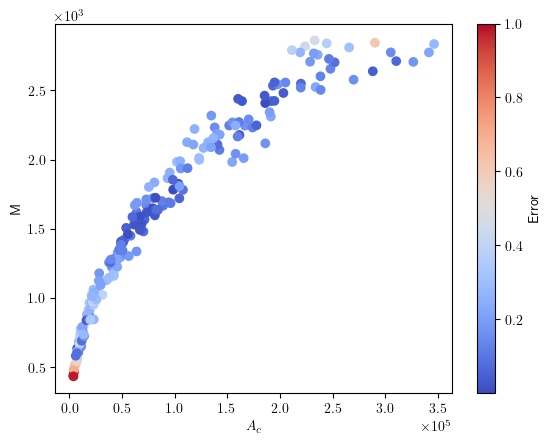

In [26]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_b)
col1 = np.abs(y_test_b - y_predict_lr_b)
col1 = col1/col1.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='coolwarm')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"Error"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/50MPa-heatmap-bound-error-predictwithclass.eps',format='eps',dpi=300)
plt.show()

In [27]:
#X_test_heatmap_b = pd.DataFrame(X_test_b)
#X_test_heatmap_b = X_test_heatmap_b.assign(A = y_predict_lr_b)
#X_test_heatmap_b = X_test_heatmap_b.drop(columns=[0,1,2,5])
#X_test_heatmap_b.to_csv("predict-bound.csv",index=False, header=False)

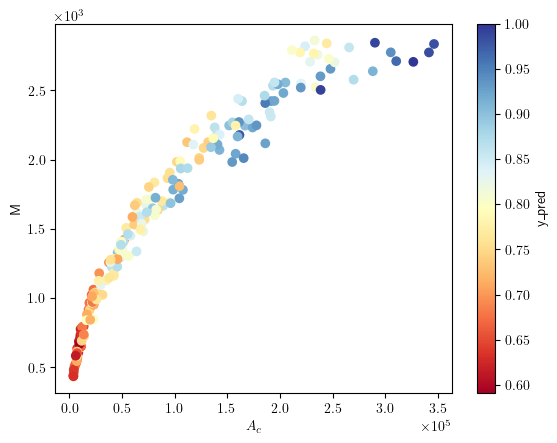

In [28]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_b)
col2 = y_test_b
col2 = col2/col2.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col2, cmap='RdYlBu')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"y_pred"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/50MPa-heatmap-bound-real.eps',format='eps',dpi=300)
plt.show()

In [29]:
col_bool = col1 == col2
col_bool[col_bool==True]

Series([], Name: 6, dtype: bool)

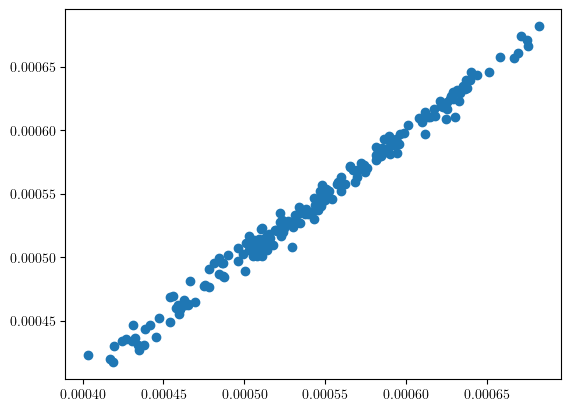

In [30]:
figsct_b1 = plt.figure()
plt.scatter(y_test_b, y_predict_rf_b)


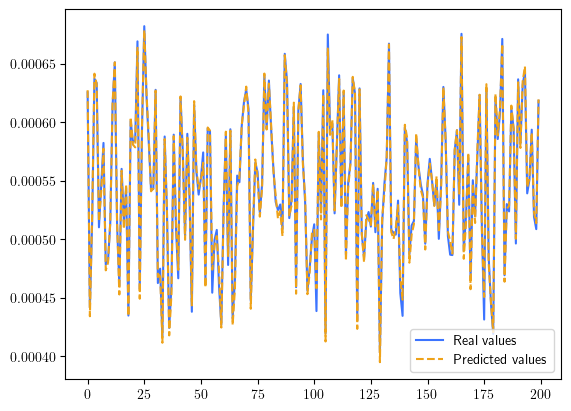

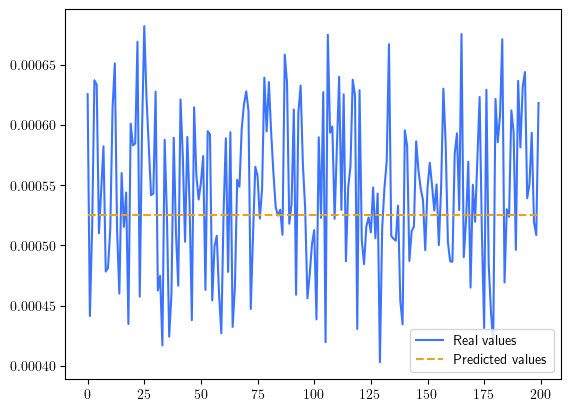

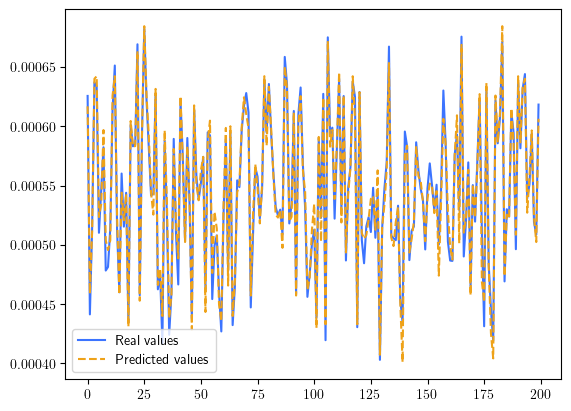

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


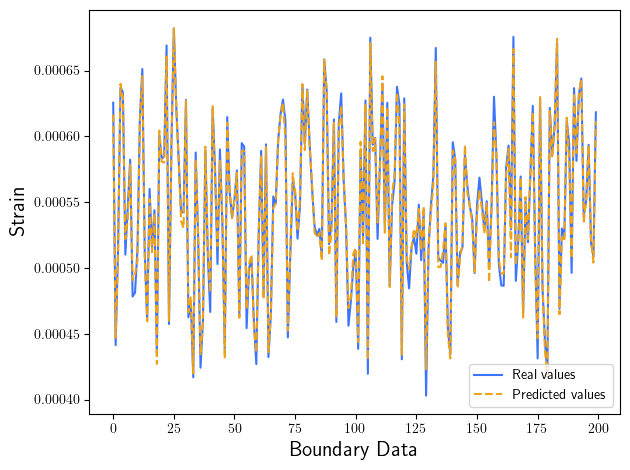

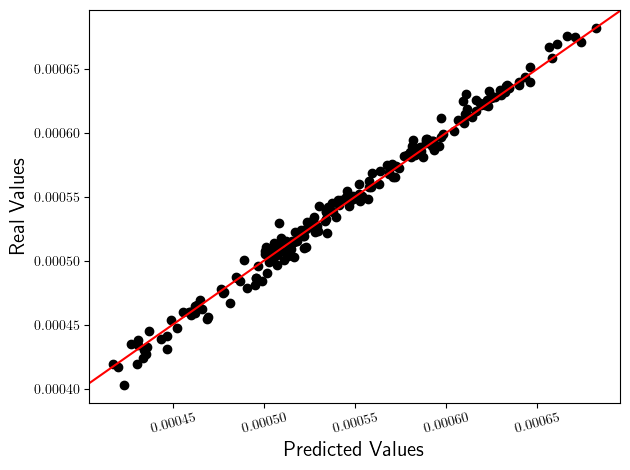

In [31]:
x=np.arange(0,len(y_test_b),1)

fig1_b = plt.figure()
plt.plot(x,y_test_b, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_lr_b, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig2_b = plt.figure()
plt.plot(x,y_test_b, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_svr_b, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig3_b = plt.figure()
plt.plot(x,y_test_b, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_dt_b, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig4_b = plt.figure()
plt.plot(x,y_test_b, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_rf_b, '--', color=nice_orange, label='Predicted values')
plt.xlabel('Boundary Data', fontsize=15)
plt.ylabel('Strain', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/50MPa-bound-regression.eps',format='eps',dpi=300)
plt.savefig('./figures/50MPa-bound-regression.svg')
plt.show()

fig_true_predict_b, ax = plt.subplots()
plt.plot(y_predict_rf_b, y_test_b, 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('./figures/50MPa-bound-regression-true-predict.eps',format='eps',dpi=300)
plt.show()

### Bound --> Kernel

In [32]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#std = StandardScaler()
#X_train_k_std = std.fit_transform(X_train_k, y_train_k)
#X_test_k_std = std.transform(X_test_k)

#### Regression Models

In [33]:
lr = LinearRegression()
lr.fit(X_train_b_std, y_train_b)
y_predict_lr_b = lr.predict(X_test_b_k_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_b_std, y_train_b)
y_predict_svr_b = svr.predict(X_test_b_k_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
mse_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_b_std, y_train_b)
    y_predict_dt_b = dt.predict(X_test_b_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_dt_b)
    mse = metrics.mean_squared_error(y_test_k, y_predict_dt_b)
    mae_dt.append(mae)
    mse_dt.append(mse)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

    
mae_rf = []
mse_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_b_std, y_train_b)
    y_predict_rf_b = rf.predict(X_test_b_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_rf_b)
    mse = metrics.mean_squared_error(y_test_k, y_predict_rf_b)
    mae_rf.append(mae)
    mse_rf.append(mse)  

#rf = RandomForestRegressor()
#rf.fit(X_train_k_std, y_train_k)
#y_predict_rf_k = rf.predict(X_test_k_b_std)
# plt.plot(y_test_k)
# plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_lr_b))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_svr_b))
#rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_dt_b))
#rmse_rf = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_rf_b))
rmse_dt = np.mean(mse_dt)
rmse_rf = np.mean(mse_rf)
print('\n', rmse_lr, '\n', rmse_svr, '\n', rmse_dt, '\n', rmse_rf, '\n', )





 0.0011276709138412157 
 0.0011481991361547072 
 1.3040712896316757e-06 
 1.3035797237249767e-06 



## Testing the Kernel + Bound

### Kernel + Bound --> Kernel

In [34]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel_bound_forKernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#### Regression models

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

lr = LinearRegression()
lr.fit(X_train_kb_std, y_train_kb)
y_predict_lr_kb = lr.predict(X_test_kb_k_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_kb_std, y_train_kb)
y_predict_svr_kb = svr.predict(X_test_kb_k_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
mse_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_kb_std, y_train_kb)
    y_predict_dt_kb = dt.predict(X_test_kb_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_dt_kb)
    mse = metrics.mean_squared_error(y_test_k, y_predict_dt_kb)
    mae_dt.append(mae)
    mse_dt.append(mse)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

mae_rf = []
mse_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_kb_std, y_train_kb)
    y_predict_rf_kb = rf.predict(X_test_kb_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_rf_kb)
    mse = metrics.mean_squared_error(y_test_k, y_predict_rf_kb)
    mae_rf.append(mae)
    mse_rf.append(mse)
    # plt.plot(y_test_k)
    # plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_lr_kb))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_svr_kb))
#rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_dt_k))
#rmse_rf = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_rf_k))
rmse_dt = np.mean(mse_dt)
rmse_rf = np.mean(mse_rf)
print('\n', rmse_lr, '\n', rmse_svr, '\n', rmse_dt, '\n', rmse_rf, '\n', )
#print(mse_dt, mse_rf)


 0.00038366692974026574 
 0.00044906331102216785 
 8.291269643958708e-08 
 3.242926283327985e-08 



### Kernel + Bound --> Bound

In [36]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#std = StandardScaler()
#X_train_k_std = std.fit_transform(X_train_k, y_train_k)
#X_test_k_std = std.transform(X_test_k)

#### Regression Models

In [37]:
lr = LinearRegression()
lr.fit(X_train_kb_std, y_train_kb)
y_predict_lr_kb = lr.predict(X_test_kb_b_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_kb_std, y_train_kb)
y_predict_svr_kb = svr.predict(X_test_kb_b_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
mse_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_kb_std, y_train_kb)
    y_predict_dt_kb = dt.predict(X_test_kb_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_dt_kb)
    mse = metrics.mean_squared_error(y_test_b, y_predict_dt_kb)
    mae_dt.append(mae)
    mse_dt.append(mse)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

    
mae_rf = []
mse_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_kb_std, y_train_kb)
    y_predict_rf_kb = rf.predict(X_test_kb_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_rf_kb)
    mse = metrics.mean_squared_error(y_test_b, y_predict_rf_kb)
    mae_rf.append(mae)
    mse_rf.append(mse)  

#rf = RandomForestRegressor()
#rf.fit(X_train_k_std, y_train_k)
#y_predict_rf_k = rf.predict(X_test_k_b_std)
# plt.plot(y_test_k)
# plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_lr_kb))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_svr_kb))
#rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_dt_k))
#rmse_rf = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_rf_k))
rmse_dt = np.mean(mse_dt)
rmse_rf = np.mean(mse_rf)
print('\n', rmse_lr, '\n', rmse_svr, '\n', rmse_dt, '\n', rmse_rf, '\n', )



 0.000401305210699202 
 0.0007246775318438826 
 3.661345079560752e-08 
 1.828434200878105e-08 



### Kernel + Bound --> Kernel + Bound

In [38]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#std = StandardScaler()
#X_train_k_std = std.fit_transform(X_train_k, y_train_k)
#X_test_k_std = std.transform(X_test_k)

#### Regression Models

In [39]:
mlp = MLPRegressor(learning_rate='constant', activation='logistic', alpha= 0.05, hidden_layer_sizes= (50, 100, 50), solver= 'adam')
mlp.fit(X_train_kb_std, y_train_kb)
y_predict_mlp_kb = mlp.predict(X_test_kb_std)
y_predict_mlp_kernel = y_predict_mlp_kb[y_test_class==0]
y_predict_mlp_bound = y_predict_mlp_kb[y_test_class==1]

lr = LinearRegression()
lr.fit(X_train_kb_std, y_train_kb)
y_predict_lr_kb = lr.predict(X_test_kb_std)
y_predict_lr_kernel = y_predict_lr_kb[y_test_class==0]
y_predict_lr_bound = y_predict_lr_kb[y_test_class==1]
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_kb_std, y_train_kb)
y_predict_svr_kb = svr.predict(X_test_kb_std)
y_predict_svr_kernel = y_predict_svr_kb[y_test_class==0]
y_predict_svr_bound = y_predict_svr_kb[y_test_class==1]
# plt.plot(y_predict_svr_k)

mae_dt = []
rmse_dt = []
r2_dt = []
mape_dt = []

mae_k_dt = []
rmse_k_dt = []
r2_k_dt = []
mape_k_dt = []

mae_b_dt = []
rmse_b_dt = []
r2_b_dt = []
mape_b_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_kb_std, y_train_kb)
    y_predict_dt_kb = dt.predict(X_test_kb_std)
    y_predict_dt_kernel = y_predict_dt_kb[y_test_class==0]
    y_predict_dt_bound = y_predict_dt_kb[y_test_class==1]
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_kb, y_predict_dt_kb)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_dt_kb))
    r2 = r2_score(y_test_kb, y_predict_dt_kb)
    mape = mean_absolute_percentage_error(y_test_kb, y_predict_dt_kb)

    mae_k = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_dt_kernel)
    rmse_k = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==0], y_predict_dt_kernel))
    r2_k = r2_score(y_test_kb[y_test_class==0], y_predict_dt_kernel)
    mape_k = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_dt_kernel)

    mae_b = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_dt_bound)
    rmse_b = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_dt_bound))
    r2_b = r2_score(y_test_kb[y_test_class==1], y_predict_dt_bound)
    mape_b = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_dt_bound)

    mae_dt.append(mae)
    rmse_dt.append(rmse)
    r2_dt.append(r2)
    mape_dt.append(mape)

    mae_k_dt.append(mae_k)
    rmse_k_dt.append(rmse_k)
    r2_k_dt.append(r2_k)
    mape_k_dt.append(mape_k)

    mae_b_dt.append(mae_b)
    rmse_b_dt.append(rmse_b)
    r2_b_dt.append(r2_b)
    mape_b_dt.append(mape_b)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

    
mae_rf = []
rmse_rf = []
r2_rf = []
mape_rf = []

mae_k_rf = []
rmse_k_rf = []
r2_k_rf = []
mape_k_rf= []

mae_b_rf = []
rmse_b_rf = []
r2_b_rf = []
mape_b_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_kb_std, y_train_kb)
    y_predict_rf_kb = rf.predict(X_test_kb_std)
    y_predict_rf_kernel = y_predict_rf_kb[y_test_class==0]
    y_predict_rf_bound = y_predict_rf_kb[y_test_class==1]
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_kb, y_predict_rf_kb)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_rf_kb))
    r2 = r2_score(y_test_kb, y_predict_rf_kb)
    mape = mean_absolute_percentage_error(y_test_kb, y_predict_rf_kb)

    mae_k = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_rf_kernel)
    rmse_k = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_rf_kernel))
    r2_k = r2_score(y_test_kb[y_test_class==0], y_predict_rf_kernel)
    mpae_k = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_rf_kernel)

    mae_b = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_rf_bound)
    rmse_b = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_rf_bound))
    r2_b = r2_score(y_test_kb[y_test_class==1], y_predict_rf_bound)
    mape_b = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_rf_bound)

    mae_rf.append(mae)
    rmse_rf.append(rmse)  
    r2_rf.append(r2)
    mape_rf.append(mape)

    mae_k_rf.append(mae_k)
    rmse_k_rf.append(rmse_k)  
    r2_k_rf.append(r2_k)
    mape_k_rf.append(mape_k)

    mae_b_rf.append(mae_b)
    rmse_b_rf.append(rmse_b)  
    r2_b_rf.append(r2_b)
    mape_b_rf.append(mape_b)

#rf = RandomForestRegressor()
#rf.fit(X_train_k_std, y_train_k)
#y_predict_rf_k = rf.predict(X_test_k_b_std)
# plt.plot(y_test_k)
# plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_lr_kb))
rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_mlp_kb))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_svr_kb))
rmse_dt = np.mean(rmse_dt)
rmse_rf = np.mean(rmse_rf)
mae_lr = metrics.mean_absolute_error(y_test_kb, y_predict_lr_kb)
mae_mlp = metrics.mean_absolute_error(y_test_kb, y_predict_mlp_kb)
mae_svr = metrics.mean_absolute_error(y_test_kb, y_predict_svr_kb)
mae_dt = np.mean(mae_dt)
mae_rf = np.mean(mae_rf)
r2_lr = r2_score(y_test_kb, y_predict_lr_kb)
r2_mlp = r2_score(y_test_kb, y_predict_mlp_kb)
r2_svr = r2_score(y_test_kb, y_predict_svr_kb)
r2_dt = np.mean(r2_dt)
r2_rf = np.mean(r2_rf)
mape_lr = mean_absolute_percentage_error(y_test_kb, y_predict_svr_kb)
mape_mlp = mean_absolute_percentage_error(y_test_kb, y_predict_mlp_kb)
mape_svr = mean_absolute_percentage_error(y_test_kb, y_predict_svr_kb)
mape_dt = np.mean(mape_dt)
mape_rf = np.mean(mape_rf)

rmse_k_lr = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==0], y_predict_lr_kernel))
rmse_k_mlp = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==0], y_predict_mlp_kernel))
rmse_k_svr = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==0], y_predict_svr_kernel))
rmse_k_dt = np.mean(rmse_k_dt)
rmse_k_rf = np.mean(rmse_k_rf)
mae_k_lr = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_lr_kernel)
mae_k_mlp = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_mlp_kernel)
mae_k_svr = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_svr_kernel)
mae_k_dt = np.mean(mae_k_dt)
mae_k_rf = np.mean(mae_k_rf)
r2_k_lr = r2_score(y_test_kb[y_test_class==0], y_predict_lr_kernel)
r2_k_mlp = r2_score(y_test_kb[y_test_class==0], y_predict_mlp_kernel)
r2_k_svr = r2_score(y_test_kb[y_test_class==0], y_predict_svr_kernel)
r2_k_dt = np.mean(r2_k_dt)
r2_k_rf = np.mean(r2_k_rf)
mape_k_lr = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_lr_kernel)
mape_k_mlp = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_mlp_kernel)
mape_k_svr = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_svr_kernel)
mape_k_dt = np.mean(mape_k_dt)
mape_k_rf = np.mean(mape_k_rf)

rmse_b_lr = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_lr_bound))
rmse_b_mlp = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_mlp_bound))
rmse_b_svr = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_svr_bound))
rmse_b_dt = np.mean(rmse_b_dt)
rmse_b_rf = np.mean(rmse_b_rf)
mae_b_lr = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_lr_bound)
mae_b_mlp = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_mlp_bound)
mae_b_svr = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_svr_bound)
mae_b_dt = np.mean(mae_b_dt)
mae_b_rf = np.mean(mae_b_rf)
r2_b_lr = r2_score(y_test_kb[y_test_class==1], y_predict_lr_bound)
r2_b_mlp = r2_score(y_test_kb[y_test_class==1], y_predict_mlp_bound)
r2_b_svr = r2_score(y_test_kb[y_test_class==1], y_predict_svr_bound)
r2_b_dt = np.mean(r2_b_dt)
r2_b_rf = np.mean(r2_b_rf)
mape_b_lr = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_lr_kernel)
mape_b_mlp = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_mlp_kernel)
mape_b_svr = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_svr_kernel)
mape_b_dt = np.mean(mape_b_dt)
mape_b_rf = np.mean(mape_b_rf)

print('Root Mean Squared Error:''\n', 'LR: ''\t', rmse_lr, '\n', 'MLP: ''\t', rmse_mlp, '\n', 'SVR: ''\t', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
print('Mean Absolute Error:''\n', 'LR: ''\t', mae_lr, '\n', 'MLP: ''\t', mae_mlp, '\n', 'SVR: ''\t', mae_svr, '\n', 'DT: ''\t', mae_dt, '\n', 'RF: ''\t', mae_rf, '\n', )
print('R2 Score:''\n', 'LR: ''\t', r2_lr, '\n', 'MLP: ''\t', r2_mlp, '\n', 'SVR: ''\t', r2_svr, '\n', 'DT: ''\t', r2_dt, '\n', 'RF: ''\t', r2_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_lr, '\n', 'MLP: ''\t', mape_mlp, '\n', 'SVR: ''\t', mape_svr, '\n', 'DT: ''\t', mape_dt, '\n', 'RF: ''\t', mape_rf, '\n', )

print('Root Mean Squared Error (kernel):''\n', 'LR: ''\t', rmse_k_lr, '\n', 'MLP: ''\t', rmse_k_mlp, '\n', 'SVR: ''\t', rmse_k_svr, '\n', 'DT: ''\t', rmse_k_dt, '\n', 'RF: ''\t', rmse_k_rf, '\n', )
print('Mean Absolute Error (kernel):''\n', 'LR: ''\t', mae_k_lr, '\n', 'MLP: ''\t', mae_k_mlp, '\n', 'SVR: ''\t', mae_k_svr, '\n', 'DT: ''\t', mae_k_dt, '\n', 'RF: ''\t', mae_k_rf, '\n', )
print('R2 Score (kernel):''\n', 'LR: ''\t', r2_k_lr, '\n', 'MLP: ''\t', r2_k_mlp, '\n', 'SVR: ''\t', r2_k_svr, '\n', 'DT: ''\t', r2_k_dt, '\n', 'RF: ''\t', r2_k_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_k_lr, '\n', 'MLP: ''\t', mape_k_mlp, '\n', 'SVR: ''\t', mape_k_svr, '\n', 'DT: ''\t', mape_k_dt, '\n', 'RF: ''\t', mape_k_rf, '\n', )

print('Root Mean Squared Error (bound):''\n', 'LR: ''\t', rmse_lr, '\n', 'MLP: ''\t', rmse_b_mlp, '\n', 'SVR: ''\t', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
print('Mean Absolute Error (bound):''\n', 'LR: ''\t', mae_b_lr, '\n', 'MLP: ''\t', mae_b_mlp, '\n', 'SVR: ''\t', mae_b_svr, '\n', 'DT: ''\t', mae_b_dt, '\n', 'RF: ''\t', mae_b_rf, '\n', )
print('R2 Score (bound):''\n', 'LR: ''\t', r2_b_lr, '\n', 'MLP: ''\t', r2_b_mlp, '\n', 'SVR: ''\t', r2_b_svr, '\n', 'DT: ''\t', r2_b_dt, '\n', 'RF: ''\t', r2_b_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_b_lr, '\n', 'MLP: ''\t', mape_b_mlp, '\n', 'SVR: ''\t', mape_b_svr, '\n', 'DT: ''\t', mape_b_dt, '\n', 'RF: ''\t', mape_b_rf, '\n', )


Root Mean Squared Error:
 LR: 	 0.0003925851405177308 
 MLP: 	 0.0005966095790899376 
 SVR: 	 0.0006028330541972353 
 DT: 	 0.00024095698616758034 
 RF: 	 0.0001603437692263598 

Mean Absolute Error:
 LR: 	 0.00034160365172423643 
 MLP: 	 0.0005604802585436353 
 SVR: 	 0.0005548173598635494 
 DT: 	 0.00011472368285487557 
 RF: 	 9.888586747093929e-05 

R2 Score:
 LR: 	 0.5393102903533366 
 MLP: 	 -0.06395005402170173 
 SVR: 	 -0.08626281098848709 
 DT: 	 0.8263587006759952 
 RF: 	 0.9231477320394175 

MAPE Score:
 LR: 	 0.7883033194614096 
 MLP: 	 0.6503573850832375 
 SVR: 	 0.7883033194614096 
 DT: 	 0.11002860722420671 
 RF: 	 0.11525595411852374 

Root Mean Squared Error (kernel):
 LR: 	 0.00038366692974026574 
 MLP: 	 0.0006616922870362859 
 SVR: 	 0.00044906331102216785 
 DT: 	 0.00028570423459904664 
 RF: 	 0.0010531982959185629 

Mean Absolute Error (kernel):
 LR: 	 0.0003278069706657095 
 MLP: 	 0.0006092689965059428 
 SVR: 	 0.0003877859053092703 
 DT: 	 0.00017846703388646029

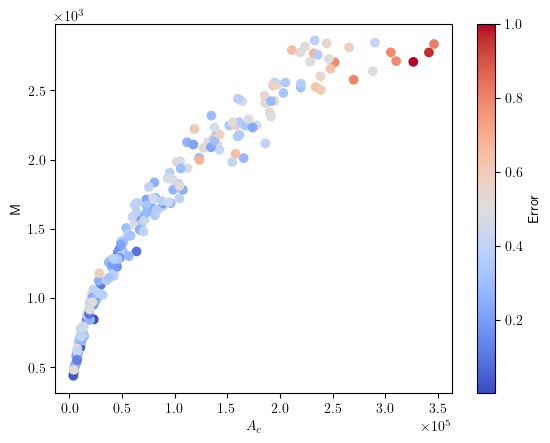

In [40]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_kb[y_test_class==1])
col1 = np.abs(y_test_kb[y_test_class==0] - y_predict_lr_bound)
col1 = col1/col1.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='coolwarm')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"Error"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/50MPa-heatmap-bound-error-predictwithoutclass.eps',format='eps',dpi=300)
plt.show()

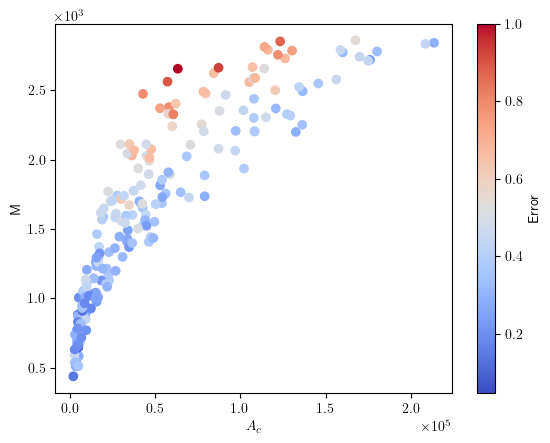

In [41]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_kb[y_test_class==0])
col1 = np.abs(y_test_kb[y_test_class==1] - y_predict_lr_kernel)
col1 = col1/col1.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='coolwarm')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"Error"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/50MPa-heatmap-kernel-error-predictwithoutclass.eps',format='eps',dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


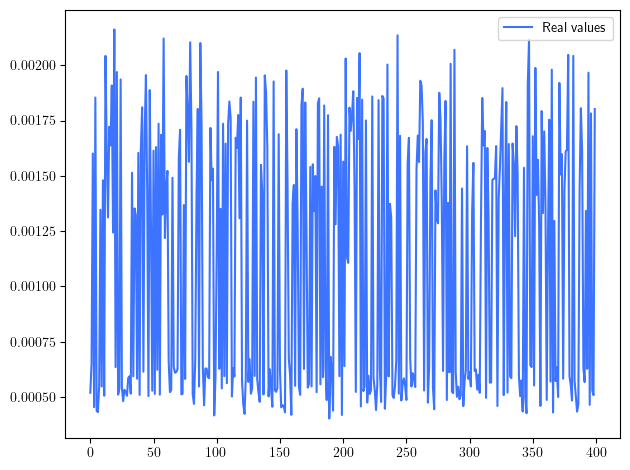

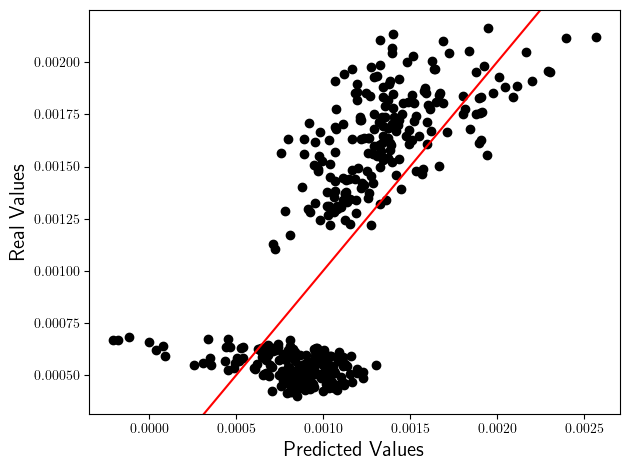

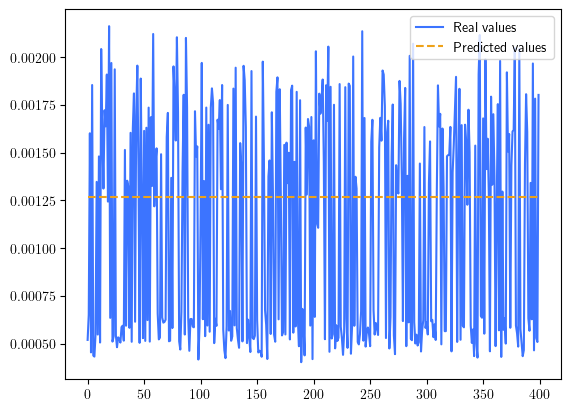

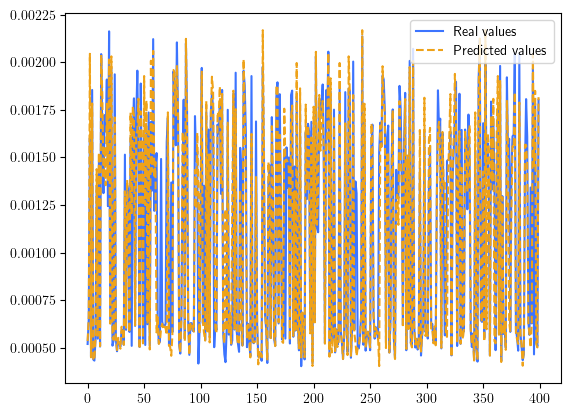

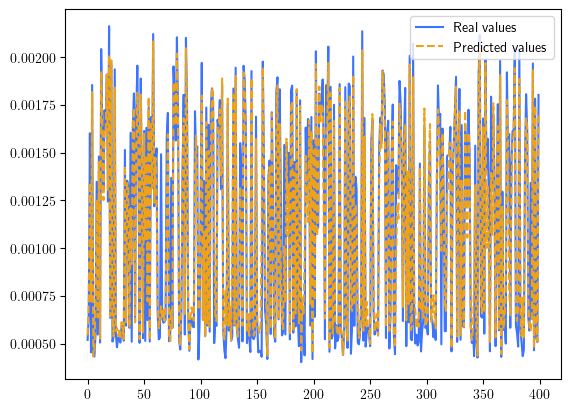

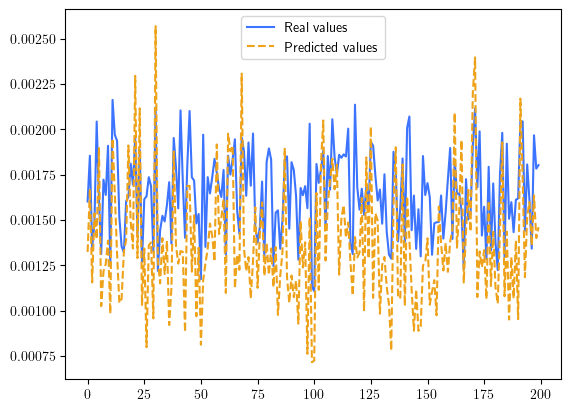

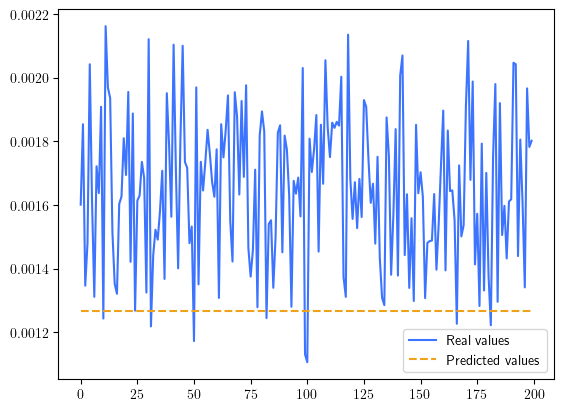

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


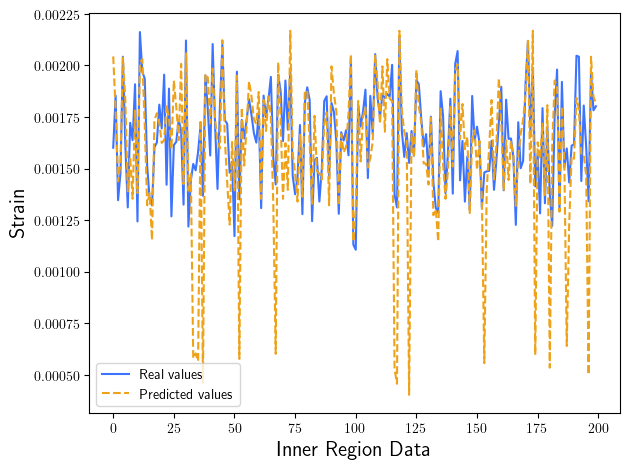

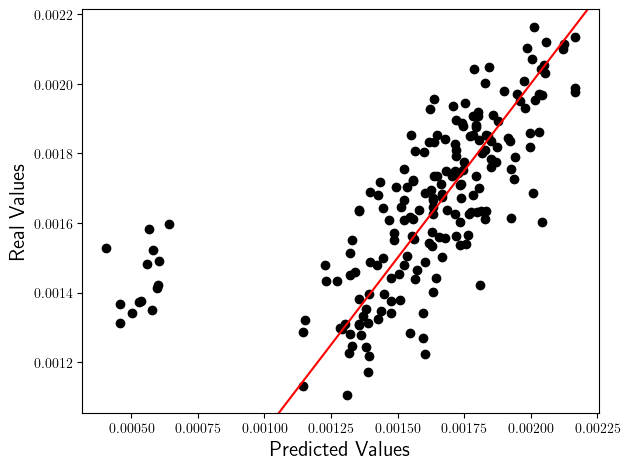

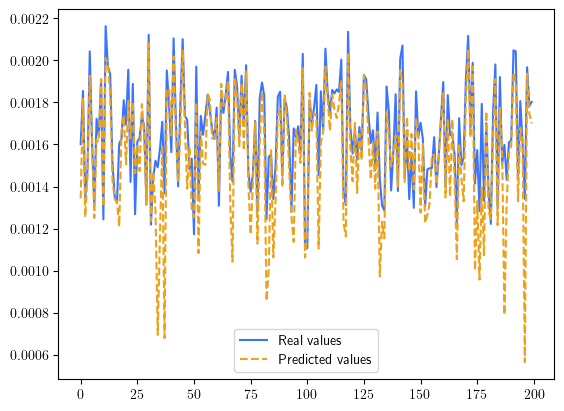

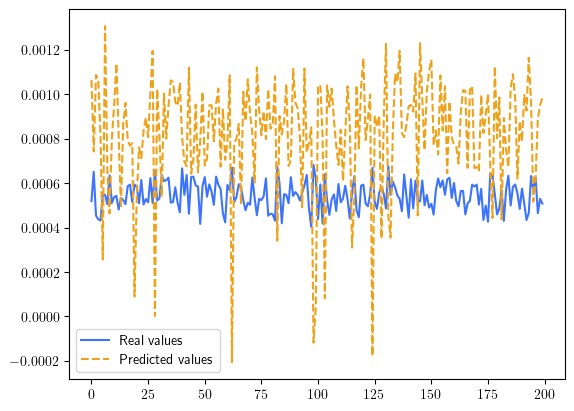

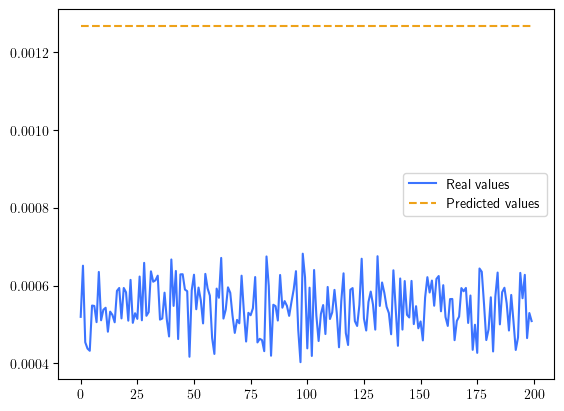

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


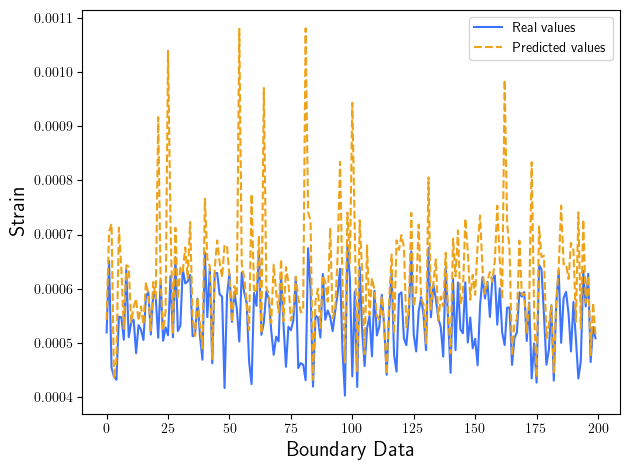

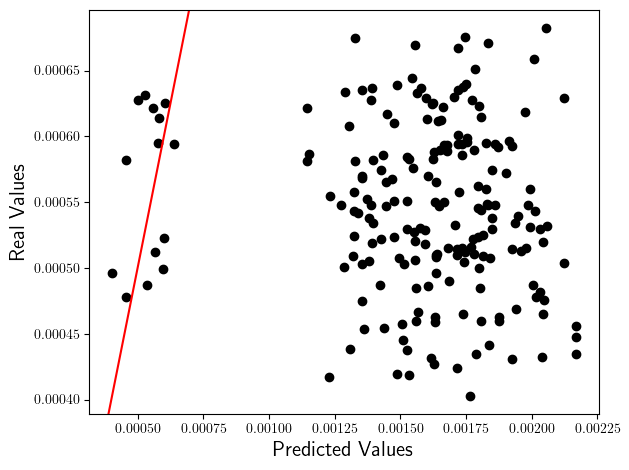

In [42]:
x=np.arange(0,len(y_test_kb),1)

fig1_kb = plt.figure()
plt.plot(x,y_test_kb, '-', color=pretty_blue, label='Real values')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/50MPa-withoutclass-regression.eps',format='eps',dpi=300)
plt.savefig('./figures/50MPa-withoutclass-regression.svg')
plt.show()

fig_true_predict_kb, ax = plt.subplots()
plt.plot(y_predict_lr_kb, y_test_kb, 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.tight_layout()
plt.savefig('./figures/50MPa-withoutclass-regression-true-predict.eps',format='eps',dpi=300)
plt.show()

fig2 = plt.figure()
plt.plot(x,y_test_kb, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_svr_kb, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig3 = plt.figure()
plt.plot(x,y_test_kb, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_dt_kb, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig4 = plt.figure()
plt.plot(x,y_test_kb, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_rf_kb, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

x2 = np.arange(0,len(y_test_kb[y_test_class==0]),1)

fig1k = plt.figure()
plt.plot(x2,y_test_kb[y_test_class==0], '-', color=pretty_blue, label='Real values')
plt.plot(x2,y_predict_lr_kernel, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig2k = plt.figure()
plt.plot(x2,y_test_kb[y_test_class==0], '-', color=pretty_blue, label='Real values')
plt.plot(x2,y_predict_svr_kernel, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig3k = plt.figure()
plt.plot(x2,y_test_kb[y_test_class==0], '-', color=pretty_blue, label='Real values')
plt.plot(x2,y_predict_dt_kernel, '--', color=nice_orange, label='Predicted values')
plt.xlabel('Inner Region Data', fontsize=15)
plt.ylabel('Strain', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/50MPa-kernel-withoutclass-regression.eps',format='eps',dpi=300)
plt.savefig('./figures/50MPa-kernel-withoutclass-regression.svg')
plt.show()

fig_true_predict_kb, ax = plt.subplots()
plt.plot(y_predict_dt_kernel, y_test_kb[y_test_class==0], 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.tight_layout()
plt.savefig('./figures/50MPa-kernel-withoutclass-regression-true-predict.eps',format='eps',dpi=300)
plt.show()

fig4k = plt.figure()
plt.plot(x2,y_test_kb[y_test_class==0], '-', color=pretty_blue, label='Real values')
plt.plot(x2,y_predict_rf_kernel, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

x3 = np.arange(0,len(y_test_kb[y_test_class==1]),1)

fig1b = plt.figure()
plt.plot(x3,y_test_kb[y_test_class==1], '-', color=pretty_blue, label='Real values')
plt.plot(x3,y_predict_lr_bound, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig2b = plt.figure()
plt.plot(x3,y_test_kb[y_test_class==1], '-', color=pretty_blue, label='Real values')
plt.plot(x3,y_predict_svr_bound, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig4b = plt.figure()
plt.plot(x3,y_test_kb[y_test_class==1], '-', color=pretty_blue, label='Real values')
plt.plot(x3,y_predict_rf_bound, '--', color=nice_orange, label='Predicted values')
plt.xlabel('Boundary Data', fontsize=15)
plt.ylabel('Strain', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/50MPa-bound-withoutclass-regression.eps',format='eps',dpi=300)
plt.savefig('./figures/50MPa-bound-withoutclass-regression.svg')
plt.show()

fig_true_predict_kb, ax = plt.subplots()
plt.plot(y_predict_dt_kernel, y_test_kb[y_test_class==1], 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.tight_layout()
plt.savefig('./figures/50MPa-bound-withoutclass-regression-true-predict.eps',format='eps',dpi=300)
plt.show()